#### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import scipy.ndimage

def halfgaussian_kernel1d(sigma, radius):
    """
    Computes a 1-D Half-Gaussian convolution kernel.
    """
    sigma2 = sigma * sigma
    x = np.arange(0, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    return phi_x

def halfgaussian_filter1d(input, sigma, axis=-1, output=None,
                      mode="constant", cval=0.0, truncate=4.0):
    """
    Convolves a 1-D Half-Gaussian convolution kernel.
    """
    sd = float(sigma)
    # make the radius of the filter equal to truncate standard deviations
    lw = int(truncate * sd + 0.5)
    weights = halfgaussian_kernel1d(sigma, lw)
    origin = -lw // 2
    return scipy.ndimage.convolve1d(input, weights, axis, output, mode, cval, origin)

In [3]:
data_path =  r'/home/teachinglab/Documents/comm-project/data/'
print(os.listdir(data_path))

['ab042_trial_data.csv', 'ab042_trial_starts.npy', 'ab042_cluster_spike_times.csv', 'ab042_spikes_dense.npy']


In [4]:
os.getcwd()

'/home/teachinglab/Documents/comm-project/code'

In [5]:

# Load trial data
fname = 'ab042_trial_data.csv'
trial_df = pd.read_csv(os.path.join(data_path,fname))
trial_df.head()

trial_type_list = ['ah', 'wh','wm','fa','cr']
for trial_type in trial_type_list:
    print('Trial type, {}, #trials = {}'.format(trial_type, sum(trial_df[trial_type])))

Trial type, ah, #trials = 83
Trial type, wh, #trials = 42
Trial type, wm, #trials = 140
Trial type, fa, #trials = 36
Trial type, cr, #trials = 211


In [6]:
trial_colors = {'ah':'mediumblue',
               'wh':'forestgreen',
               'wm':'crimson',
               'fa':'k',
               'cr':'dimgray'}

#### Load neuron data

In [7]:
fname = 'ab042_cluster_spike_times.csv'
neuron_df = pd.read_csv(os.path.join(data_path,fname))
neuron_df.head()

,mouse_name,probe_id,cluster_id,n_spikes,fr,depth,sh,ch,amp,ks_label,group,curated,contam_pct,amplitude,spike_times,area
0,AB042,1,11,18844,3.355170,140,0,12,2.61722,good,good,1,0.0,80.7,[4.58315428e+00 4.82023206e+00 4.99889605e+00 ...,OFC
1,AB042,1,15,82884,14.757500,160,0,15,3.78658,good,good,1,0.0,117.2,[1.19608207e-01 1.19832537e+00 1.26132442e+00 ...,OFC
2,AB042,1,18,22369,3.982790,200,0,18,3.74118,good,good,1,0.2,155.9,[ 16.12826086 16.20829299 16.22845936 ......,OFC
3,AB042,1,25,103197,18.374200,260,0,25,2.54027,good,good,1,0.4,51.9,[9.13752968e-02 1.98307027e-01 3.14838613e-01 ...,OFC
4,AB042,1,27,5487,0.976959,260,0,25,2.98611,good,good,1,9.9,39.2,[3.04006209e+00 3.06686169e+00 3.21399281e+00 ...,OFC


In [8]:
areas = np.unique(neuron_df.area, return_counts=True)
print(areas)
area_list = areas[0]
print(area_list)

(array(['DLS', 'DS', 'OFC', 'Thalamus', 'nS1', 'tjM1', 'wM2', 'wS1'],
      dtype=object), array([135,  30,  72, 139, 121, 166, 126,  58]))
['DLS' 'DS' 'OFC' 'Thalamus' 'nS1' 'tjM1' 'wM2' 'wS1']


#### Load spike time data

In [9]:
fname = 'ab042_spikes_dense.npy'
spike_array = np.load(os.path.join(data_path,fname))
spike_array.shape

(847, 512, 401)

In [10]:
#### PSTHs

all_psths = {}

for trial_type in trial_type_list:
    all_psths[trial_type] = {}
    trial_indices = trial_df[trial_df[trial_type]==1].index.values

    for area in area_list:
        neuron_indices = neuron_df[neuron_df.area==area].index.values
        #print('Number of neurons:', len(neuron_indices))

        spike_array_sub = spike_array[neuron_indices][:,trial_indices,:]
        all_psths[trial_type][area] = spike_array_sub
        #spike_array_sub_bas = spike_array_sub[:,:,0:100]
        #bas = np.mean(spike_array_sub_bas)
        #print('Sub array dim', spike_array_sub.shape)
        
        


In [11]:
all_psths.keys()

dict_keys(['ah', 'wh', 'wm', 'fa', 'cr'])

In [12]:
all_psths["ah"]["DLS"].shape

(135, 83, 401)

In [13]:
for area in all_psths["ah"].keys():
    print(area, all_psths["ah"][area].shape)

DLS (135, 83, 401)
DS (30, 83, 401)
OFC (72, 83, 401)
Thalamus (139, 83, 401)
nS1 (121, 83, 401)
tjM1 (166, 83, 401)
wM2 (126, 83, 401)
wS1 (58, 83, 401)


In [14]:
sigma_smooth = 0.1
tjm1_raw = all_psths["ah"]["tjM1"][np.random.choice(np.arange(all_psths["ah"]["tjM1"].shape[0]),135),:,100:]
# TODO: keep all neurons

tjm1 = halfgaussian_filter1d(tjm1_raw, sigma=sigma_smooth)
print(tjm1.shape)
dls_raw = all_psths["ah"]["DLS"][:,:,100:]
dls = halfgaussian_filter1d(dls_raw, sigma=sigma_smooth)

print(dls.shape)

n_trials = dls.shape[1]
print(n_trials)

(135, 83, 301)
(135, 83, 301)
83


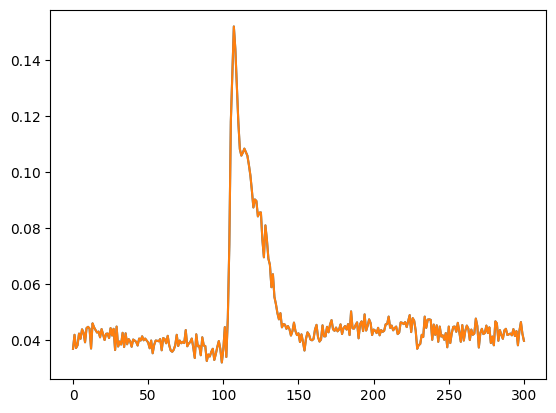

In [15]:
plt.figure()
#plt.plot(dls_raw.mean(axis=(0,1)))
#plt.plot(dls.mean(axis=(0,1)))

plt.plot(tjm1_raw.mean(axis=(0,1)))
plt.plot(tjm1.mean(axis=(0,1)))


In [16]:
re_tjm1 = tjm1.reshape(tjm1.shape[0], -1)
print(re_tjm1.shape)
re_dls = dls.reshape(dls.shape[0], -1)
print(re_dls.shape)

(135, 24983)
(135, 24983)


In [17]:
mc_tjm1 = re_tjm1 - re_tjm1.mean(axis=1)[:,np.newaxis]
mc_dls = re_dls - re_dls.mean(axis=1)[:,np.newaxis]

In [18]:
from sklearn.decomposition import PCA

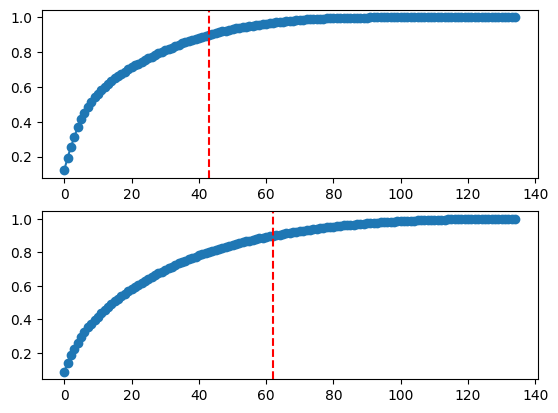

In [19]:
pca_tjm1 = PCA()
pca_tjm1.fit(mc_tjm1)

pca_dls = PCA()
pca_dls.fit(mc_dls)

fig, ax = plt.subplots(2,1)
ax[0].plot(np.cumsum(pca_tjm1.explained_variance_ratio_), marker="o")
ax[0].axvline(np.argmin(np.abs(np.cumsum(pca_tjm1.explained_variance_ratio_)-0.9)), linestyle="--", c="red")
ax[1].plot(np.cumsum(pca_dls.explained_variance_ratio_), marker="o")
ax[1].axvline(np.argmin(np.abs(np.cumsum(pca_dls.explained_variance_ratio_)-0.9)), linestyle="--", c="red")

In [20]:
n_latents = 70
pca_tjm1 = PCA(n_components=n_latents) # TODO: cross/validate train and test
proj_tjm1 = pca_tjm1.fit_transform(mc_tjm1.T)

pca_dls = PCA(n_components=n_latents)
proj_dls = pca_dls.fit_transform(mc_dls.T)

In [21]:
print(proj_tjm1.shape)
print(proj_dls.shape)

(24983, 70)
(24983, 70)


In [22]:
re_proj_tjm1 = proj_tjm1.reshape(-1,n_trials, n_latents)
re_proj_dls = proj_dls.reshape(-1,n_trials, n_latents)
print(re_proj_tjm1.shape)

(301, 83, 70)


In [23]:
from statsmodels.multivariate.cancorr import CanCorr

In [24]:
cc = CanCorr(proj_tjm1, proj_dls)

In [25]:
ccdims1 = cc.y_cancoef
ccdims2 = cc.x_cancoef

In [26]:
print(ccdims1.shape)
print(ccdims2.shape)

(70, 70)
(70, 70)


In [27]:
cc.cancorr.shape

(70,)

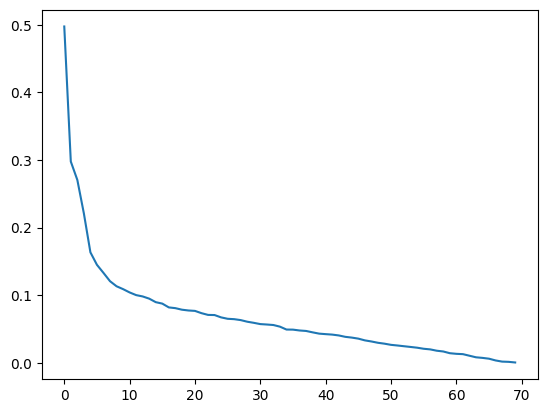

In [28]:
plt.plot(cc.cancorr)

In [29]:
#cc = CanCorr(proj_tjm1, proj_dls)

ccdims1 = cc.y_cancoef
ccdims2 = cc.x_cancoef

ccend_proj_tjm1 = proj_tjm1 @ ccdims1
ccexog_proj_dls = proj_dls @ ccdims2


print(ccend_proj_tjm1.shape)
print(ccexog_proj_dls.shape)

(24983, 70)
(24983, 70)


In [30]:
ccend_proj_tjm1_trials = ccend_proj_tjm1.reshape(-1,n_trials,n_latents)
ccexog_proj_dls_trials = ccexog_proj_dls.reshape(-1,n_trials,n_latents)
print(ccend_proj_tjm1_trials.shape)

ccend_proj_tjm1_trials[:,:,0].mean(axis=1).shape

(301, 83, 70)


(301,)

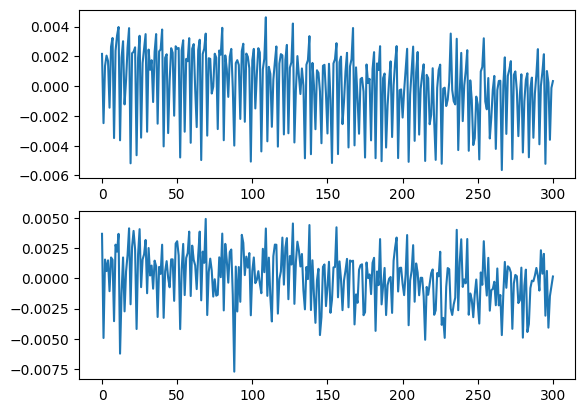

In [31]:
fig, ax = plt.subplots(2,1)
ax[0].plot(ccend_proj_tjm1_trials[:,:,0].mean(axis=1))
ax[1].plot(ccexog_proj_dls_trials[:,:,0].mean(axis=1))

In [32]:
np.corrcoef(ccend_proj_tjm1_trials[:,:,0].mean(axis=1), ccexog_proj_dls_trials[:,:,0].mean(axis=1))[0,1]

0.7909016558663798

In [33]:
all_corrs = {}
for i in range(70):
    c_corr = np.corrcoef(ccend_proj_tjm1_trials[:,:,i].mean(axis=1), ccexog_proj_dls_trials[:,:,i].mean(axis=1))[0,1]
    all_corrs[i] = c_corr
    

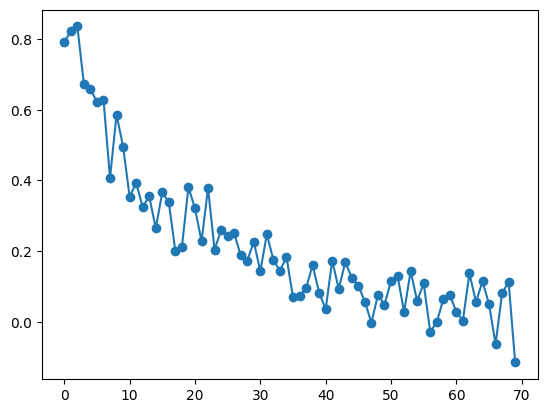

In [34]:
fig, ax = plt.subplots()
ax.plot(all_corrs.keys(), all_corrs.values(), marker="o")

(301, 83, 3)


NameError: name 'ccend_proj_dls_trials' is not defined

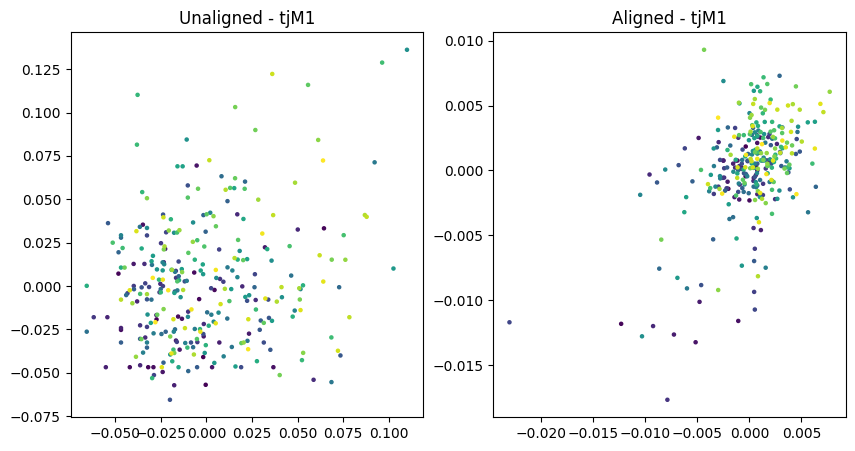

In [35]:
%matplotlib inline

cc_tjm1 = ccend_proj_tjm1_trials[:,:,:3]

print(cc_tjm1.shape)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)

ax.set_title('Unaligned - tjM1')

im = ax.scatter(re_proj_tjm1[:,0].mean(axis=1),
       re_proj_tjm1[:,1].mean(axis=1),
               c=np.linspace(0.2,0.8,301), s=5)

ax = fig.add_subplot(1,2,2)
ax.set_title('Aligned - tjM1')

im = ax.scatter(cc_tjm1[:,0].mean(axis=1),
       cc_tjm1[:,1].mean(axis=1),
                c=np.linspace(0.2,0.8,301), s=5)


cc_dls = ccend_proj_dls_trials[:,:,:3]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)

ax.set_title('Unaligned - DLS')

im = ax.scatter(re_proj_dls[:,0].mean(axis=1),
       re_proj_dls[:,1].mean(axis=1),
               c=np.linspace(0.2,0.8,301), s=5)

ax = fig.add_subplot(1,2,2)
ax.set_title('Aligned - DLS')

im = ax.scatter(cc_dls[:,0].mean(axis=1),
       cc_dls[:,1].mean(axis=1),
                c=np.linspace(0.2,0.8,301), s=5)

In [ ]:
%matplotlib inline

cc_tjm1 = ccend_proj_tjm1_trials[:,:,:3]

print(cc_tjm1.shape)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection="3d")

ax.set_title('Unaligned - tjM1')

im = ax.scatter(re_proj_tjm1[:,0].mean(axis=1),
       re_proj_tjm1[:,1].mean(axis=1),
       re_proj_tjm1[:,2].mean(axis=1),
               c=np.linspace(0.2,0.8,301))

ax = fig.add_subplot(1,2,2,projection="3d")
ax.set_title('Aligned - tjM1')

im = ax.scatter(cc_tjm1[:,0].mean(axis=1),
       cc_tjm1[:,1].mean(axis=1),
       cc_tjm1[:,2].mean(axis=1), 
                c=np.linspace(0.2,0.8,301))


cc_dls = ccend_proj_dls_trials[:,:,:3]


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1,projection="3d")

ax.set_title('Unaligned - DLS')

im = ax.scatter(re_proj_dls[:,0].mean(axis=1),
       re_proj_dls[:,1].mean(axis=1),
       re_proj_dls[:,2].mean(axis=1),
               c=np.linspace(0.2,0.8,301))

ax = fig.add_subplot(1,2,2,projection="3d")
ax.set_title('Aligned - DLS')

im = ax.scatter(cc_dls[:,0].mean(axis=1),
       cc_dls[:,1].mean(axis=1),
       cc_dls[:,2].mean(axis=1), 
                c=np.linspace(0.2,0.8,301))

In [ ]:
%matplotlib ipympl

cc_tjm1 = ccend_proj_tjm1_trials[:,:,:3].mean(axis=1)
cc_dls = ccexog_proj_dls_trials[:,:,:3].mean(axis=1)

print(cc_tjm1.shape)


fig = plt.figure()
ax = fig.add_subplot()

t_idx=0
im = ax.scatter(cc_tjm1[:,0],
       cc_tjm1[:,1],
               c=plt.get_cmap('Reds')(
    np.linspace(0.15, 0.85, 301)))

im = ax.scatter(cc_dls[:,0],
       cc_dls[:,1],
               c=plt.get_cmap('Greys')(
    np.linspace(0.15, 0.85, 301)))




In [36]:
### Correlation over areas

In [43]:
def preprocess(area):
    wind = all_psths["ah"][area][:,:,100:]
    smooth = halfgaussian_filter1d(wind, sigma=sigma_smooth)
    re_sm = smooth.reshape(smooth.shape[0], -1)
    re_sm_m = re_sm - re_sm.mean(axis=1)[:,np.newaxis]
    
    n_latents = 10
    pca_area = PCA(n_components=n_latents) # Denoise using PCA
    proj_area = pca_area.fit_transform(re_sm_m.T)
    
    return proj_area

In [ ]:
out = preprocess()

In [42]:
for area in all_psths['ah'].keys():
    wind = all_psths["ah"][area][:,:,100:]
    smooth = halfgaussian_filter1d(wind, sigma=sigma_smooth)
    re_sm = smooth.reshape(smooth.shape[0], -1)
    re_sm_m = re_sm - re_sm.mean(axis=1)[:,np.newaxis]
    
    n_latents = 10
    pca_area = PCA(n_components=n_latents) # Denoise using PCA
    proj_area = pca_area.fit_transform(re_sm_m.T)
    

    #print(proj_area.shape)

(24983, 10)
(24983, 10)
(24983, 10)
(24983, 10)
(24983, 10)
(24983, 10)
(24983, 10)
(24983, 10)


In [49]:
mat = []
for areaix,areaiv in enumerate all_psths['ah'].keys():
    for areajx, areajv in enumerate all_psths['ah'].keys(): 
        area1 = preprocess(areaiv)
        area2 = preprocess(areajv)
        
        cc = CanCorr(area1, area2)
        print(cc.cancorr.shape)
        
        #ccdims1 = cc.x_cancoef
        #ccdims2 = cc.y_cancoef

        #ccend_area1 = area1 @ ccdims1
        #ccexog_area2 = area2 @ ccdims2
        mat[areaix][areajx] = cc.cancorr

        
        


SyntaxError: invalid syntax (738540022.py, line 2)